In [1]:
import pandas as pd
import numpy as np
import spacy
from pathlib import Path
import os
from spacy import displacy
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain
import re

In [3]:
# Load simple language model, need to download this spacy en dictionary ahead of time
NER = spacy.load("en_core_web_sm")

### Get the Books

In [4]:
cwd = Path.cwd()
bookdir = cwd / 'books'

# Traverse and get all names
p = Path(bookdir).glob('**/*')
booklist = [x for x in p if x.is_file()]

print(booklist)

[PosixPath('/mnt/d/Algorant/witcher_nlp/books/1 The Last Wish.txt'), PosixPath('/mnt/d/Algorant/witcher_nlp/books/2 The Sword of Destiny.txt'), PosixPath('/mnt/d/Algorant/witcher_nlp/books/3 Blood of Elves.txt'), PosixPath('/mnt/d/Algorant/witcher_nlp/books/4 Times of Contempt.txt'), PosixPath('/mnt/d/Algorant/witcher_nlp/books/5 Baptism of Fire.txt'), PosixPath('/mnt/d/Algorant/witcher_nlp/books/6 The Tower of the Swallow.txt'), PosixPath('/mnt/d/Algorant/witcher_nlp/books/7 The Lady of the Lake.txt'), PosixPath('/mnt/d/Algorant/witcher_nlp/books/8 something ends something begins.txt')]


In [5]:
book = booklist[0]
book_text = open(book).read()
book_doc = NER(book_text)

In [6]:
# Visualize using displacy
displacy.render(book_doc[0:200], style="ent", jupyter=True)

### Import Character List and Clean Up

In [7]:
# Load Character dfs
characters = pd.read_csv('./characters/characters.csv')
characters

,book,character
0,Category:Baptism of Fire characters,Adalia
1,Category:Baptism of Fire characters,Adela
2,Category:Baptism of Fire characters,Aen Saevherne
3,Category:Baptism of Fire characters,Aevenien
4,Category:Baptism of Fire characters,Aglaïs
...,...,...
1270,Category:Time of Contempt characters,Yanna of Murivel
1271,Category:Time of Contempt characters,Yarpen Zigrin
1272,Category:Time of Contempt characters,Yennefer of Vengerberg
1273,Category:Time of Contempt characters,Yiolenta Suarez


In [8]:
# Remove brackets and text within brackets using regex
characters['character'] = characters['character'].apply(lambda x: re.sub("[\(].*?[\)]", "", x))
# If name is split, ie Geralt of Rivia, get only first part
characters['character_firstname'] = characters['character'].apply(lambda x: x.split(' ', 1)[0])
# Make exception for "Two Tusks", because first name of "Two" causes problems
characters['character_firstname'] = characters['character_firstname'].replace(['Two'], 'Two Tusks')
characters.tail(30)

,book,character,character_firstname
1245,Category:Time of Contempt characters,Stahler,Stahler
1246,Category:Time of Contempt characters,Stefan Skellen,Stefan
1247,Category:Time of Contempt characters,Stella Congreve,Stella
1248,Category:Time of Contempt characters,Talbot,Talbot
1249,Category:Time of Contempt characters,Tangerinka Hofmeier,Tangerinka
1250,Category:Time of Contempt characters,Tissaia de Vries,Tissaia
1251,Category:Time of Contempt characters,Torm Akerspaark,Torm
1252,Category:Time of Contempt characters,Toruviel,Toruviel
1253,Category:Time of Contempt characters,Toublanc Michelet,Toublanc
1254,Category:Time of Contempt characters,Triss Merigold,Triss


### Get Named Entity List Per Sentence

In [9]:
sentence_entities = []

# Loop and find all
for sentence in book_doc.sents:
    entity_list = [ent.text for ent in sentence.ents]
    sentence_entities.append({"sentence": sentence, "entities": entity_list})
    
sentence_entities = pd.DataFrame(sentence_entities)

In [10]:
sentence_entities

,sentence,entities
0,"(﻿'Does, she, always, devour, her, victims, ?,...",[]
1,"(Velerad, spat, vehemently, on, the, straw, .)",[]
2,"(\n\n, ', Come, on, ,, Geralt, ,, it, 'll, be,...",[Geralt]
3,"(Pish, !)",[]
4,"(Devours, ,, takes, a, bite, ,, leaves, aside,...",[]
...,...,...
8967,"(See, to, Iola, .)",[Iola]
8968,"(So, long, ,, Nenneke, ., ')",[Nenneke]
8969,"(The, priestess, slowly, shook, her, head, ,, ...",[]
8970,(\n\n),[]


### Filter out all entities

In [11]:
def filter_entity(entity_list, characters):
    return [ent for ent in entity_list
            if ent in list(characters.character)
            or ent in list(characters.character_firstname)]

In [12]:
filter_entity(["Geralt", "Thu", "Ciri", "Nenneke", "Two"], characters)

['Geralt', 'Ciri', 'Nenneke']

### Apply filter function to dataframe

In [13]:
sentence_entities['character_entities'] = sentence_entities['entities'].apply(lambda x: filter_entity(x, characters))

# Remove sentences where there are no named entities
sentence_entities_filtered = sentence_entities[sentence_entities['character_entities'].map(len) > 0]

In [14]:
# Take only first name of character in entities
sentence_entities_filtered['character_entities'] = sentence_entities_filtered['character_entities'].apply(lambda x: [item.split()[0]
                                                                                               for item in x])


/tmp/ipykernel_17859/1885442398.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentence_entities_filtered['character_entities'] = sentence_entities_filtered['character_entities'].apply(lambda x: [item.split()[0]


In [15]:
sentence_entities_filtered

,sentence,entities,character_entities
2,"(\n\n, ', Come, on, ,, Geralt, ,, it, 'll, be,...",[Geralt],[Geralt]
6,"(Damned, mother's-, !, ', \n\n, ', Careful, ,,...","[Velerad, Ostrit]","[Velerad, Ostrit]"
7,"(', Say, what, you, want, about, the, striga, ...",[Adda],[Adda]
10,"(Segelin, and, Ostrit, looked, at, each, other...","[Segelin, Ostrit]","[Segelin, Ostrit]"
15,"(And, then, ,, ', interrupted, Velerad, ,, ', ...","[Velerad, miller]",[Velerad]
...,...,...,...
8947,"(Nenneke, raised, herself, to, her, knees, and...",[Nenneke],[Nenneke]
8954,"(She, turned, to, Geralt, .)",[Geralt],[Geralt]
8958,"(Iola-, ', \n\n, ', Do, n't, say, anything, ,,...",[Nenneke],[Nenneke]
8967,"(See, to, Iola, .)",[Iola],[Iola]


### Create rolling windows throughout the text and do analysis

In [16]:
window_size = 5
relationships = []

for i in range(sentence_entities_filtered.index[-1]):
    end_index = min(i+5, sentence_entities_filtered.index[-1])
    character_list = sum((sentence_entities_filtered.loc[i: end_index].character_entities), [])
    
    # Remove duplicates that are next to each other:
    unique_characters = [character_list[i] for i in range(len(character_list))
                         if (i==0) or character_list[i] !=character_list[i-1]]
    
    if len(unique_characters) > 1:
        for index, a in enumerate(unique_characters[:-1]):
            b = unique_characters[index + 1]
            relationships.append({"source": a, "target": b})

In [17]:
relationships = pd.DataFrame(relationships)
relationships

,source,target
0,Geralt,Velerad
1,Velerad,Ostrit
2,Geralt,Velerad
3,Velerad,Ostrit
4,Ostrit,Adda
...,...,...
1702,Iola,Nenneke
1703,Iola,Nenneke
1704,Iola,Nenneke
1705,Iola,Nenneke


### Aggregate the relationships

In [18]:
### First need to sort order so its uniform

relationships = pd.DataFrame(np.sort(relationships.values, axis=1), columns = relationships.columns)
relationships

,source,target
0,Geralt,Velerad
1,Ostrit,Velerad
2,Geralt,Velerad
3,Ostrit,Velerad
4,Adda,Ostrit
...,...,...
1702,Iola,Nenneke
1703,Iola,Nenneke
1704,Iola,Nenneke
1705,Iola,Nenneke


In [19]:
# For each row make the value 1 and sum
relationships["value"] = 1
relationships = relationships.groupby(["source", "target"], sort=False, as_index=False).sum()

In [20]:
relationships

,source,target,value
0,Geralt,Velerad,8
1,Ostrit,Velerad,7
2,Adda,Ostrit,5
3,Adda,Segelin,3
4,Ostrit,Segelin,6
...,...,...,...
165,Count,Geralt,4
166,Dennis,Geralt,22
167,Dennis,Falwick,5
168,Count,Dennis,6


### Part 3: Graph visualization with networkx

In [21]:
# Create graph from df

G = nx.from_pandas_edgelist(relationships,
                            source="source",
                            target="target",
                            edge_attr="value",
                            create_using=nx.Graph())

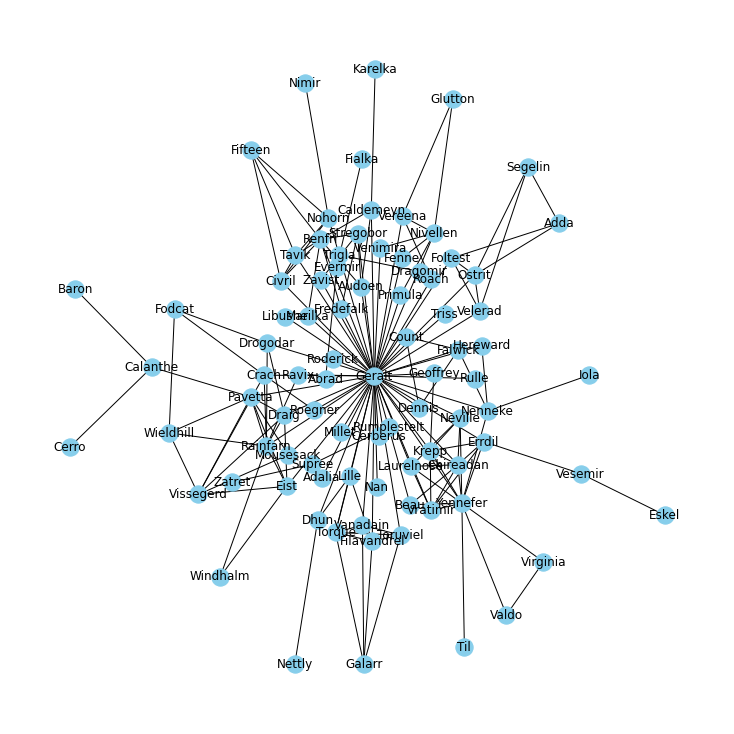

In [22]:
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)

nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

### Use PyVis instead

In [24]:
from pyvis.network import Network
net = Network(notebook=True, width="1000px", height="700px", bgcolor="#222222", font_color="white")

# Make node size relative
node_degree = dict(G.degree)

# Setting up node size
nx.set_node_attributes(G, node_degree, "size")

# Pass in networkx Graph G
net.from_nx(G)
net.show("witcher.html")

### More fun analysis, attempting to find most important characters

In [25]:
# Degree centrality
degree_dict = nx.degree_centrality(G)
degree_dict

{'Geralt': 0.6588235294117647,
 'Velerad': 0.047058823529411764,
 'Ostrit': 0.058823529411764705,
 'Adda': 0.03529411764705882,
 'Segelin': 0.03529411764705882,
 'Foltest': 0.047058823529411764,
 'Nenneke': 0.058823529411764705,
 'Yennefer': 0.1411764705882353,
 'Iola': 0.011764705882352941,
 'Roach': 0.023529411764705882,
 'Rulle': 0.011764705882352941,
 'Nivellen': 0.07058823529411765,
 'Fenne': 0.023529411764705882,
 'Primula': 0.023529411764705882,
 'Venimira': 0.023529411764705882,
 'Glutton': 0.023529411764705882,
 'Vereena': 0.047058823529411764,
 'Falwick': 0.047058823529411764,
 'Hereward': 0.023529411764705882,
 'Dragomir': 0.011764705882352941,
 'Trigla': 0.011764705882352941,
 'Caldemeyn': 0.047058823529411764,
 'Karelka': 0.011764705882352941,
 'Stregobor': 0.058823529411764705,
 'Zavist': 0.023529411764705882,
 'Evermir': 0.023529411764705882,
 'Fialka': 0.011764705882352941,
 'Abrad': 0.011764705882352941,
 'Fredefalk': 0.03529411764705882,
 'Renfri': 0.10588235294117647

<AxesSubplot:>

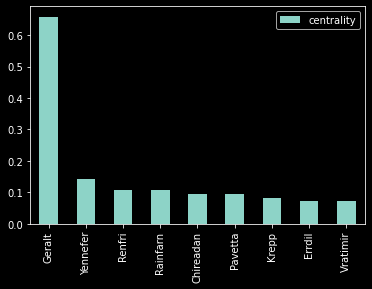

In [26]:
degrees = pd.DataFrame.from_dict(degree_dict, orient="index", columns=['centrality'])
# Plot top 10
plt.style.use('dark_background') #For dark backgrounds
degrees.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<AxesSubplot:>

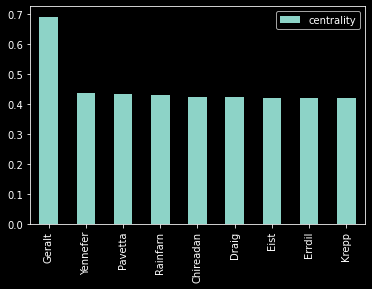

In [27]:
# Closeness centrality
closeness_dict = nx.closeness_centrality(G)
closeness = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
# Plot the top 10
closeness.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<AxesSubplot:>

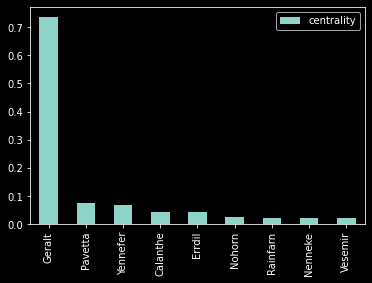

In [28]:
# Betweeness centrality
betweenness_dict = nx.betweenness_centrality(G)
betweenness = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
# Plot the top 10
betweenness.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

In [29]:
# Save centrality measure

nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')

#### Community Detection

In [30]:
communities = community_louvain.best_partition(G)

In [32]:
nx.set_node_attributes(G, communities, 'group')

In [33]:
com_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#00000F', font_color='white')
com_net.from_nx(G)
com_net.show("witcher_communities.html")

In [34]:
# Save to png
com_net.savefig('./graphs/colored_book1.png')

AttributeError: 'Network' object has no attribute 'savefig'

## Misc

#### Find this "two"

In [ ]:
characters

In [ ]:
find_two_chars = characters.loc[characters['character'].str.contains('Two', case=False)]
find_two_chars

In [ ]:
find_two_src = relationships.loc[relationships['source'].str.contains('Two', case=False)]
find_two_tar = relationships.loc[relationships['target'].str.contains('Two', case=False)]
find_two_src

In [ ]:
for p in Path(bookdir).iterdir():
    print(p)

In [ ]:
booklist = [x for x in os.listdir(bookdir) if x.endswith(".txt")]
booklist

In [ ]:
book = booklist[0]
book_text